In [1]:
import os
import pycolmap
import sys
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from IPython.display import clear_output
from helpers import *
import locale

In [2]:
datasets_full = {
    "eth3d_raw_dslr": [
        "courtyard",
        "delivery_area",
        "electro",
        "facade",
        "kicker",
        "meadow",
        "office",
        "pipes",
        "playground",
        "relief",
        "relief_2",
        "terrace",
        "terrains"
    ],
}

reconstruction_file_names = ["cameras.bin", "images.bin", "points3D.bin"]

In [ ]:
        "kicker",
        "meadow",
        "office",
        "pipes",
        "playground",
        "relief",
        "relief_2",
        "terrace",
        "terrains"
    ],
}

reconstruction_file_names = ["cameras.bin", "images.bin", "points3D.bin"]

In [3]:
# base dirs
path_roots = {"eth3d_raw_dslr":
        "/home/yihan/cvg/datasets/ETH3D/",}

In [4]:
roots = ["eth3d_raw_dslr"]
path_bases = ["colmap_thinprism/0", "colmap_radial/0", "implicit_sfm", "radial_sfm", "upgraded_radialsfm"]

In [10]:
# results for relative pose
results = {}
results_r = {}
total_image = {}
errors_r_all = []
errors_t_all = []
for root in roots:
    results[root] = {}
    results_r[root] = {}
    total_image[root] = {}
    if datasets_full[root] is None:
        datasets_full[root] = sorted([x for x in os.listdir(path_roots[root]) if os.path.isdir(path_roots[root] + x)], key=locale.strxfrm)
    for dataset in datasets_full[root]:
        dir_base = path_roots[root] + dataset + "/"
        print("Processing", dir_base)

        # generate gt centers
        gt_path = os.path.join(dir_base, "dslr_calibration_jpg/images.txt")
        out_path = os.path.join(dir_base, "centers_gt_clean.txt")
        # if not os.path.exists(out_path):
        image_centers = parse_file(gt_path)
        with open(out_path, "w") as f:
            for name, center in image_centers:
                # pre-add "dslr_images/" to the name
                # name = "dslr_images/" + name
                f.write(name + " " + " ".join([str(x) for x in center]) + "\n")
        # generate gt poses
        out_path = os.path.join(dir_base, "gtpose_trans.txt")
        if not os.path.exists(out_path):
            image_poses = parse_file_pose(gt_path)
            with open(out_path, "w") as f:
                for name, pose in image_poses:
                    f.write(name + " " + " ".join([str(x) for x in pose]) + "\n")
        print(dataset)
        results[root][dataset] = []
        results_r[root][dataset] = []
        database_path = os.path.join(dir_base, "implicit_single.db")
        print(database_path)
        image_path = os.path.join(dir_base, "images")
        print(image_path)

        for path_base in path_bases:
            if path_base is None:
                results[root][dataset].append(None)
                results_r[root][dataset].append(None)
                continue
            
            if not os.path.exists(os.path.join(dir_base, path_base, "cameras.txt")) and not os.path.exists(os.path.join(dir_base, path_base, "cameras.bin")):
                print(os.path.join(dir_base, path_base), "not possible")
                results[root][dataset].append(None)
                results_r[root][dataset].append(None)
                continue
            
            # Only use the txt files as they are directly generated
            for name in reconstruction_file_names:
                if os.path.exists(os.path.join(dir_base, path_base, name)) and os.path.exists(os.path.join(dir_base, path_base, name[:-4]+ ".txt")):
                    # change implicit_distortion camera.txt to have Simple Pinhole camera model
                    if name == "cameras.bin":
                        cameras = pycolmap.read_cameras_binary(os.path.join(dir_base, path_base, name))
                        for camera_id in cameras.keys():
                            cameras[camera_id].model = "SIMPLE_PINHOLE"
                        pycolmap.write_cameras_text(cameras, os.path.join(dir_base, path_base, name[:-4]+ ".txt"))
                    
                    os.remove(os.path.join(dir_base, path_base, name))
                    print("removed", os.path.join(dir_base, path_base, name))
                    
            status = True
            key_words = ["sparse", "colmap_thinprism", "colmap_radial", "radial_sfm", "upgraded_radialsfm"] 
            for key_word in key_words:
                if path_base.find(key_word + "/0") >= 0:
                    total_dirs = sorted([x for x in os.listdir(dir_base + key_word + "") if os.path.isdir(dir_base + key_word + "/" + x)])
                    if len(total_dirs) > 1:
                        # num_imgs = []
                        max_num_img = 0
                        max_idx = -1
                        for idx, sub_dir in enumerate(total_dirs):
                            reconstruction = pycolmap.Reconstruction()
                            reconstruction.read(dir_base + key_word + "/" + sub_dir)
                            if reconstruction.num_images() > max_num_img:
                                max_num_img = reconstruction.num_images()
                                max_idx = idx
                        if max_idx != 0:
                            status = False
                            path_base = key_word + "/" + str(max_idx)
                            print("path_base:", path_base)

            file = open(dir_base + "centers_gt.txt", "r")
            centers_gt = {}
            names = []
            centers = []
            for line in file:
                line = line.split()
                centers_gt[line[0]] = np.array([float(line[1]), float(line[2]), float(line[3])])
                names.append(line[0])
                centers.append(centers_gt[line[0]])


            file = open(dir_base + "gtpose_trans.txt", "r")
            poses_gt = {}
            for line in file:
                line = line.split()
                poses_gt[line[0]] = poselib.CameraPose()
                poses_gt[line[0]].q = np.array([float(line[1]), float(line[2]), float(line[3]), float(line[4])])
                poses_gt[line[0]].t = np.array([float(line[5]), float(line[6]), float(line[7])])

            # reconstruction = pycolmap.Reconstruction()
            # reconstruction.read(dir_base + path_base)

            # poses_calc = {}
            # for image_name in centers_gt.keys():
            #     image = reconstruction.find_image_with_name(image_name)
            #     if image is not None:
            #         pose = poselib.CameraPose()
            #         pose.q = image.cam_from_world.rotation.quat[[3,0,1,2]]
            #         pose.t = image.cam_from_world.translation
            #         poses_calc[image_name] = pose

            # poses_gt_list = np.array([poses_gt[x] for x in sorted(poses_gt.keys())])
            # poses_calc_list = np.array([poses_calc[x] if x in poses_calc else None for x in sorted(poses_gt.keys())])
                
            # # centers_est = {}
            # errors_r = []
            # errors_t = []
            # pose = poselib.CameraPose()
            # image_names = sorted(list(centers_gt.keys()))

            
            # errors_r_ori = np.array(errors_r)
            # errors_t_ori = np.array(errors_t)

            # errors_r, errors_t = calc_pairwise_relative_error_batch(poses_gt_list, poses_calc_list)

            # errors_r_all += list(errors_r)
            # errors_t_all += list(errors_t)
            
            # errors_t = np.array(errors_t)
            # # errors_r = np.array(errors_r)
            # results[root][dataset].append(np.maximum(errors_r, errors_t))
            # # results[root][dataset].append(errors_r)
            # results_r[root][dataset].append(errors_r)
            # total_image[root][dataset] = len(centers_gt)

Processing /home/yihan/cvg/datasets/ETH3D/courtyard/
courtyard
/home/yihan/cvg/datasets/ETH3D/courtyard/implicit_single.db
/home/yihan/cvg/datasets/ETH3D/courtyard/images
/home/yihan/cvg/datasets/ETH3D/courtyard/colmap_thinprism/0 not possible
/home/yihan/cvg/datasets/ETH3D/courtyard/radial_sfm not possible
/home/yihan/cvg/datasets/ETH3D/courtyard/upgraded_radialsfm not possible
Processing /home/yihan/cvg/datasets/ETH3D/delivery_area/
delivery_area
/home/yihan/cvg/datasets/ETH3D/delivery_area/implicit_single.db
/home/yihan/cvg/datasets/ETH3D/delivery_area/images
/home/yihan/cvg/datasets/ETH3D/delivery_area/colmap_thinprism/0 not possible
/home/yihan/cvg/datasets/ETH3D/delivery_area/colmap_radial/0 not possible
/home/yihan/cvg/datasets/ETH3D/delivery_area/implicit_sfm not possible
/home/yihan/cvg/datasets/ETH3D/delivery_area/radial_sfm not possible
/home/yihan/cvg/datasets/ETH3D/delivery_area/upgraded_radialsfm not possible
Processing /home/yihan/cvg/datasets/ETH3D/electro/
electro
/hom

In [10]:
def rankify(x, order):
    # Turn a vector of values into a list of ranks, while handling ties.
    assert len(x.shape) == 1
    if order == 0:
        return np.full_like(x, 1e5, dtype=np.int32)
    u = np.sort(np.unique(x))
    if order == 1:
        u = u[::-1]
    r = np.zeros_like(x, dtype=np.int32)
    for ui, uu in enumerate(u):
        mask = x == uu
        r[mask] = ui
    return np.int32(r)

In [12]:
roots_rel = ["eth3d_rig", "mip360", "eth3d_dslr", "eth3d_dslr_test", "imc_haiper", "imc_heritage", "imc_urban", "imc_phototourism", "imc2024", "KITTI", "euroc", "eth3d_raw_dslr", "blendedmvs"]
roots_abs = ["lamar_map", "eth3d_slam", "strecha"]

results_full = [[] for i in range(len(path_bases))]
results_table = []
for root in roots:
    if root in roots_abs:
        mode = "abs"
    elif root in roots_rel:
        mode = "rel"
    else:
        print("NOT KNOWN!!!")
    
    # mode = 'abs'
    if mode == "rel":
        if root.find("eth3d_dslr") >= 0:
            threshold = 1
            AUC_thres =  [1, 3, 5]
            # threshold = 0.02
            # AUC_thres =  [0.02, 0.05, 0.1]
        elif root == "eth3d_rig":
            threshold = 1
            AUC_thres = [1, 3, 5]
            # threshold = 0.02
            # AUC_thres =  [0.02, 0.05, 0.1]
        elif root == "eth3d_slam":
            # threshold = 1
            # AUC_thres = [3, 5, 10]
            threshold = 0.02
            AUC_thres =  [0.02, 0.05, 0.1]
        elif root.find("imc") >= 0:
            threshold = 3
            AUC_thres = [3, 5, 10]
        elif root == "mip360":
            threshold = 3
            AUC_thres = [3, 5, 10]
        elif root == "KITTI":
            threshold = 1
            AUC_thres = [0.5, 1, 2]
        elif root == "euroc":
            threshold = 1
            AUC_thres = [0.5, 1, 2]
        else:
            threshold = 1
            AUC_thres = [1, 3, 5]
        idx = list(range(len(AUC_thres) + 2))[1:]
    elif mode == "abs":
        if root == "lamar_map":
            threshold = 1
            AUC_thres = [1, 5]
        elif root == "eth3d_slam":
            threshold = 0.1
            AUC_thres = [0.1, 0.5]
        else:
            threshold = 0.1
            AUC_thres = [0.1, 0.5]
        idx = list(range(len(AUC_thres) + 2))
    print(threshold, AUC_thres)

    results_class = {}
    for dataset in datasets_full[root]:
        if root == "eth3d_slam":
            prefix = dataset.split("_")[0]
        else:
            prefix = dataset
        # prefix = dataset

        if prefix not in results_class:
            results_class[prefix] = {path_base: [] for path_base in path_bases}

        result_row = []
        times_row = []
        for i, path_base in enumerate(path_bases):
            if path_base is None:
                continue
            if results[root][dataset][i] is None:
                continue
            inliers = results[root][dataset][i] < threshold

            row = []
            row.append(np.average(results[root][dataset][i] < threshold) * 100)
            row += compute_auc(results[root][dataset][i], AUC_thres)
            result_row.append(row)

            if path_base == "colmap" or path_base == "colmap/0" or path_base.find("sparse") >= 0:
                if dataset in times_colmap[root]:
                    result_row[-1].append(times_colmap[root][dataset])
                else:
                    result_row[-1].append(1e10)
                # result_row[-1].append(times_colmap[root][dataset])
            elif path_base.find("theia") != -1:
                if dataset in times_theia:
                    result_row[-1].append(times_theia[dataset])
                elif dataset in times_theia[root]:
                    result_row[-1].append(times_theia[root][dataset])
                else:
                    result_row[-1].append(1e10)
            elif path_base.find("openmvg") != -1:
                result_row[-1].append(times_openmvg[dataset])
            elif path_base.find("ligt") != -1:
                result_row[-1].append(times_ligt[dataset])
            elif post_fixes[i] is not None:
                if post_fixes[i] in times_3d:
                    if dataset in times_3d[post_fixes[i]][root]:
                        result_row[-1].append(times_3d[post_fixes[i]][root][dataset])
                    elif dataset in times_3d[post_fixes[i]]:
                        result_row[-1].append(times_3d[post_fixes[i]][dataset])
                    else:
                        result_row[-1].append(1e10)
                else:
                    result_row[-1].append(1e10)
            else:
                if post_fix in times_3d:
                    if dataset in times_3d[post_fix][root]:
                        result_row[-1].append(times_3d[post_fix][root][dataset])
                    else:
                        result_row[-1].append(1e10)
                else:
                    result_row[-1].append(1e10)
            
            results_class[prefix][path_base].append(result_row[-1])
            results_full[i].append(result_row[-1])

        # result_row = np.asarray(result_row)
        # result_row = np.round(result_row, 2)
    # print(results_class)
    
    prefix_full = sorted(list(results_class.keys()))
    for prefix in prefix_full:
        print(prefix.replace("_", "\\_"), end=" ")
        result_row = []
        max_rows = np.max([len(results_class[prefix][path_base]) for path_base in path_bases])
        for path_base in path_bases:
            if len(results_class[prefix][path_base]) == 0:
                result_row.append(np.zeros((len(AUC_thres) + 2,)))
                result_row[-1][-1] = 1e10
                continue
            result_row.append(np.sum(np.asarray(results_class[prefix][path_base]), axis=0) / max_rows)
            result_row[-1][-1] = np.mean(np.asarray(results_class[prefix][path_base])[:,-1], axis=0)
        

        result_row = np.asarray(result_row)
        result_row = np.round(result_row, 1)

        ranks = [rankify(result_row[:, i], 1) for i in range(result_row.shape[1])]
        ranks[-1] = rankify(result_row[:, -1], -1)

        
        for j in idx[:-1]:
            print("&", end="")
            counter = 0
            for i, path_base in enumerate(path_bases):
                if prefix in results[root] and results[root][prefix][i] is None:
                    print("& -", end=" ")
                    counter += 1
                    continue
                    
                if ranks[j][counter] == 0:
                    print("& \\cellcolor{tabfirst}" + "{:.1f}".format(result_row[i][j]), end=" ")
                elif ranks[j][counter] == 1:
                    print("& \\cellcolor{tabsecond}" + "{:.1f}".format(result_row[i][j]), end=" ")
                # elif ranks[j][counter] == 2:
                #     print("& \\cellcolor{tabthird}" + "{:.1f}".format(result_row[i][j]), end=" ")

                # if ranks[j][counter] == 0:
                #     print("& \\textbf{" + "{:.1f}".format(result_row[i][j]) + "}", end=" ")
                # elif ranks[j][counter] == 1:
                #     print("& \\textit{" + "{:.1f}".format(result_row[i][j]) + "}", end=" ")
                # elif ranks[j][counter] == 2:
                #     print("& \\cellcolor{tabthird}" + "{:.1f}".format(result_row[i][j]), end=" ")
                else:
                    print("& " + "{:.1f}".format(result_row[i][j]), end=" ")
                counter += 1
        print("\\\\")
                
        # for j in idx:
        #     counter = 0
        #     for i, path_base in enumerate(path_bases):
        #         if prefix in results[root] and results[root][prefix][i] is None:
        #             print("& -", end=" ")
        #             counter += 1
        #             continue
                    
        #         print(" " + "{:.1f}".format(result_row[i][j]), end=" ")
        #         counter += 1
            
        # print()
        

result_full_average = []
result_full_average_valid = []
results_test = []

total_dataset = 0
for root in roots:
    total_dataset += len(datasets_full[root])
for i in range(len(path_bases)):
    if len(results_full[i]) == 0:
        result_full_average.append(np.nan * np.zeros((len(idx),)))
        continue

    results_test.append(np.asarray(results_full[i])[0])

    result_full_np = np.asarray(results_full[i])
    result_full_average.append(np.sum(result_full_np, axis=0) / total_dataset)
    result_full_average[-1][-1] = np.mean(result_full_np[:, -1])
    result_full_average_valid.append(np.mean(result_full_np, axis=0))

result_full_average = np.asarray(result_full_average)
result_full_average_valid = np.asarray(result_full_average_valid)

result_full_average = np.round(result_full_average, 1)
result_full_average_valid = np.round(result_full_average_valid, 1)
ranks_ave = [rankify(result_full_average[:, i], 1) for i in range(result_full_average.shape[1])]
ranks_ave[-1] = rankify(result_full_average[:, -1], -1)

print("\\midrule")
print("\\textit{Average}", end=" ")

for j in idx:
    print("&", end="")
    counter = 0
    for i, path_base in enumerate(path_bases):
        if np.isnan(result_full_average[i][0]):
            print("& " + "-", end=" ")
            counter += 1
            continue
        if ranks_ave[j][counter] == 0:
            print("& \\cellcolor{tabfirst}" + "{:.1f}".format(result_full_average[i][j]), end=" ")
        elif ranks_ave[j][counter] == 1:
            print("& \\cellcolor{tabsecond}" + "{:.1f}".format(result_full_average[i][j]), end=" ")
        # elif ranks_ave[j][counter] == 2:
        #     print("& \\cellcolor{tabthird}" + "{:.1f}".format(result_full_average[i][j]), end=" ")
        # if ranks_ave[j][counter] == 0:
        #     print("& \\textbf{" + "{:.1f}".format(result_full_average[i][j]) + "}", end=" ")
        # elif ranks_ave[j][counter] == 1:
        #     print("& \\t
        # extit{" + "{:.1f}".format(result_full_average[i][j]) + "}", end=" ")
        else:
            print("& " + "{:.1f}".format(result_full_average[i][j]), end=" ")
        # print("& " + "{:.1f}".format(result_full_average[i][j]), end=" ")delivery\_area && \cellcolor{tabsecond}92.3 & \cellcolor{tabfirst}92.8 & 87.6 && \cellcolor{tabsecond}97.4 & \cellcolor{tabfirst}97.6 & 95.9 && \cellcolor{tabsecond}98.5 & \cellcolor{tabfirst}98.6 & 97.5 \\

            
        counter += 1
print("\\\\")


1 [1, 3, 5]
courtyard && - & - & - & - & - && - & - & - & - & - && - & - & - & - & - \\
facade && - & - & - & - & - && - & - & - & - & - && - & - & - & - & - \\
\midrule
\textit{Average} && - & - & - & - & - && - & - & - & - & - && - & - & - & - & - && - & - & - & - & - \\


In [3]:
def read_rebuttal_file(file_path):
    numbers_start = False
    all_numbers = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            # Start collecting numbers after the "Kalibr" line
            if line == "Kalibr":
                numbers_start = True
                continue
            if numbers_start:
                try:
                    # Convert each line into a list of floats and add to the collection
                    row = eval(line)  # Safely parse the list from the file
                    all_numbers.append(row)
                except:
                    # Stop reading if invalid data (e.g., a new header) is encountered
                    break

    # Convert the collected data into a NumPy array
    return np.array(all_numbers)
    # return np.asarray(results)
control_3_data = read_rebuttal_file('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/rebuttal/control_3_results.txt')

In [4]:

control_3_BF2M2020S23 = control_3_data[:,:,0][:,0]
control_3_BF5M13720 = control_3_data[:,:,0][:,1]
control_3_BM2820 = control_3_data[:,:,0][:,2]
control_3_BM4018S118 = control_3_data[:,:,0][:,3]
control_3_ENTANIYA = control_3_data[:,:,0][:,4]
control_3_EUROC = control_3_data[:,:,0][:,5]
control_3_GOPRO = control_3_data[:,:,0][:,6]
control_3_TUMVI = control_3_data[:,:,0][:,7]

control_5_data = read_rebuttal_file('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/rebuttal/control_5_results.txt')
control_5_BF2M2020S23 = control_5_data[:,:,0][:,0]
control_5_BF5M13720 = control_5_data[:,:,0][:,1]
control_5_BM2820 = control_5_data[:,:,0][:,2]
control_5_BM4018S118 = control_5_data[:,:,0][:,3]
control_5_ENTANIYA = control_5_data[:,:,0][:,4]
control_5_EUROC = control_5_data[:,:,0][:,5]
control_5_GOPRO = control_5_data[:,:,0][:,6]
control_5_TUMVI = control_5_data[:,:,0][:,7]

control_8_data = read_rebuttal_file('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/rebuttal/control_8_results.txt')
control_8_BF2M2020S23 = control_8_data[:,:,0][:,0]
control_8_BF5M13720 = control_8_data[:,:,0][:,1]
control_8_BM2820 = control_8_data[:,:,0][:,2]
control_8_BM4018S118 = control_8_data[:,:,0][:,3]
control_8_ENTANIYA = control_8_data[:,:,0][:,4]
control_8_EUROC = control_8_data[:,:,0][:,5]
control_8_GOPRO = control_8_data[:,:,0][:,6]
control_8_TUMVI = control_8_data[:,:,0][:,7]

control_10_data = read_rebuttal_file('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/rebuttal/control_10_results.txt')
control_10_BF2M2020S23 = control_10_data[:,:,0][:,0]
control_10_BF5M13720 = control_10_data[:,:,0][:,1]
control_10_BM2820 = control_10_data[:,:,0][:,2]
control_10_BM4018S118 = control_10_data[:,:,0][:,3]
control_10_ENTANIYA = control_10_data[:,:,0][:,4]
control_10_EUROC = control_10_data[:,:,0][:,5]
control_10_GOPRO = control_10_data[:,:,0][:,6]
control_10_TUMVI = control_10_data[:,:,0][:,7]

control_12_data = read_rebuttal_file('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/rebuttal/control_12_results.txt')
control_12_BF2M2020S23 = control_12_data[:,:,0][:,0]
control_12_BF5M13720 = control_12_data[:,:,0][:,1]
control_12_BM2820 = control_12_data[:,:,0][:,2]
control_12_BM4018S118 = control_12_data[:,:,0][:,3]
control_12_ENTANIYA = control_12_data[:,:,0][:,4]
control_12_EUROC = control_12_data[:,:,0][:,5]
control_12_GOPRO = control_12_data[:,:,0][:,6]
control_12_TUMVI = control_12_data[:,:,0][:,7]

control_15_data = read_rebuttal_file('/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/rebuttal/control_15_results.txt')
control_15_BF2M2020S23 = control_15_data[:,:,0][:,0]
control_15_BF5M13720 = control_15_data[:,:,0][:,1]
control_15_BM2820 = control_15_data[:,:,0][:,2]
control_15_BM4018S118 = control_15_data[:,:,0][:,3]
control_15_ENTANIYA = control_15_data[:,:,0][:,4]
control_15_EUROC = control_15_data[:,:,0][:,5]
control_15_GOPRO = control_15_data[:,:,0][:,6]
control_15_TUMVI = control_15_data[:,:,0][:,7]



In [4]:

control_15_TUMVI

array([0.23293569, 0.23328863, 0.23310772, 0.23336028, 0.23206001])

0.18523527497759584 0.2073992922271947
0.2590098829429661 0.3160585977928779
0.1560820750314122 0.16583180052773547
0.20257026902573635 0.23316951904353236
0.19166233748477238 0.27171198094863536
0.18439231611957568 0.19531814083468743
0.22937662282876828 0.235479150087439
0.4767377924887629 0.4874315389452652


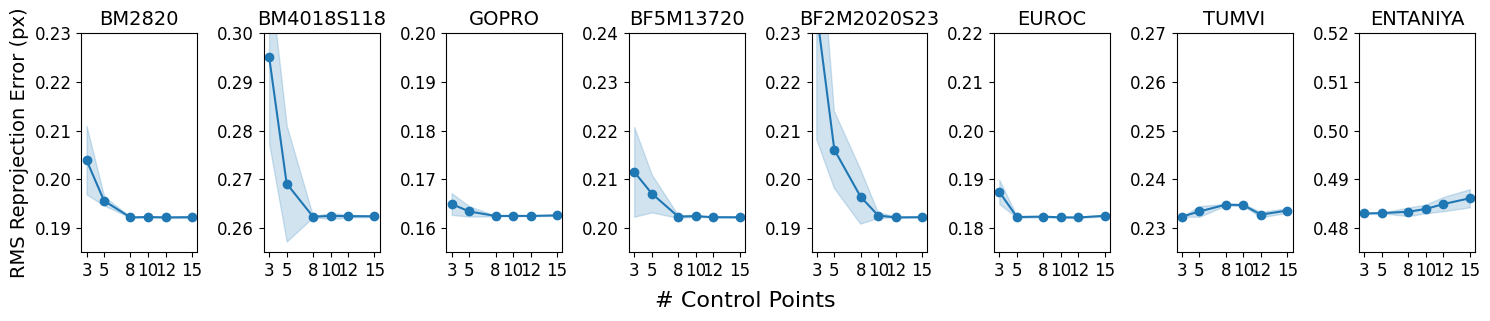

In [5]:
# Define control points
control_points = np.array([3, 5, 8, 10, 12, 15])

# Data for each camera
BF2M2020S23 = np.array([
    control_3_BF2M2020S23, control_5_BF2M2020S23, control_8_BF2M2020S23, 
    control_10_BF2M2020S23, control_12_BF2M2020S23, control_15_BF2M2020S23
])

BF5M13720 = np.array([
    control_3_BF5M13720, control_5_BF5M13720, control_8_BF5M13720, 
    control_10_BF5M13720, control_12_BF5M13720, control_15_BF5M13720
])

BM2820 = np.array([
    control_3_BM2820, control_5_BM2820, control_8_BM2820, 
    control_10_BM2820, control_12_BM2820, control_15_BM2820
])

BM4018S118 = np.array([
    control_3_BM4018S118, control_5_BM4018S118, control_8_BM4018S118, 
    control_10_BM4018S118, control_12_BM4018S118, control_15_BM4018S118
])

ENTANIYA = np.array([
    control_3_ENTANIYA, control_5_ENTANIYA, control_8_ENTANIYA, 
    control_10_ENTANIYA, control_12_ENTANIYA, control_15_ENTANIYA
])

EUROC = np.array([
    control_3_EUROC, control_5_EUROC, control_8_EUROC, 
    control_10_EUROC, control_12_EUROC, control_15_EUROC
])

GOPRO = np.array([
    control_3_GOPRO, control_5_GOPRO, control_8_GOPRO, 
    control_10_GOPRO, control_12_GOPRO, control_15_GOPRO
])

TUMVI = np.array([
    control_3_TUMVI, control_5_TUMVI, control_8_TUMVI, 
    control_10_TUMVI, control_12_TUMVI, control_15_TUMVI
])

# Camera names
cameras = ["BM2820", "BM4018S118", "GOPRO", "BF5M13720", "BF2M2020S23", "EUROC" ,"TUMVI", "ENTANIYA"]
camera_data = [BM2820, BM4018S118, GOPRO,  BF5M13720, BF2M2020S23, EUROC, TUMVI, ENTANIYA]

# Plot settings
fig, axes = plt.subplots(1, len(cameras), figsize=(15, 3), sharex=True, sharey=False)
for ax, cam_name, data in zip(axes, cameras, camera_data):
    if data.size == 0:  # Skip empty datasets
        continue
    mean_errors = np.mean(data, axis=1)
    std_errors = np.std(data, axis=1)
    ymin = np.min(data)-0.002 
    ymax = np.max(data)+0.001
    print(ymin, ymax)

    ax.plot(control_points, mean_errors, marker='o', linestyle='-', color='tab:blue')
    ax.fill_between(control_points, mean_errors - std_errors, mean_errors + std_errors, color='tab:blue', alpha=0.2)
    
    ax.set_title(cam_name, fontsize=14)
    ax.set_xticks(control_points)
    # set xticks fontsize
    ax.xaxis.set_tick_params(labelsize=12)
    
    grid = 0.01
    ax.set_ylim(ymin-0.005, ymin+4*grid)
    yticks = np.array([ymin,ymin+grid, ymin+2*grid, ymin+3*grid, ymin+4*grid])  # Create 5 y-tick levels
    # print(yticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{yt:.2f}" for yt in yticks])  # Format yticks
    ax.yaxis.set_tick_params(labelsize=12)
    # # ax.yaxis.set_visible(True)
    # # ax.tick_params(axis='y', which='both', labelleft=True)
    # # **Force y-ticks to always be visible**
    # ax.yaxis.set_tick_params(labelleft=True)
    # # show y ticks for each subplot/
    
    
    

axes[0].set_ylabel("RMS Reprojection Error (px)", fontsize=14)
fig.text(0.5, -0.04, "# Control Points", ha='center', fontsize=16)
# fig.subplots_adjust(left=0.05, right=0.98, bottom=0.2, top=0.85, wspace=0.1)
plt.tight_layout()
plt.show()

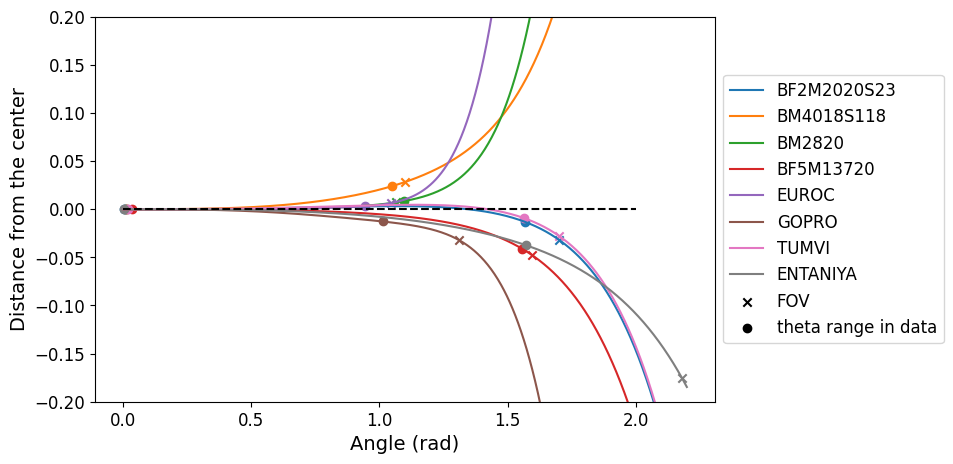

In [50]:
import numpy as np
import matplotlib.pyplot as plt

ks = {
"BF2M2020S23": (0.00664694, -0.00398977, 0.00078898, -0.0003372
),
"BF5M13720": (-0.00419185, -0.00046744, -0.00028093, -0.00027411), 
"BM2820": (-0.00578425, 0.02294664, -0.02003667, 0.00781314),
 "BM4018S118": (0.01569357, 0.00715324, -0.00438781, 0.00187269),
 "ENTANIYA": (-6.75767747e-03, -1.26083375e-03, 2.83627052e-04, -9.81737223e-05),
 "EUROC": (-0.00671247, 0.03581091, -0.04771274, 0.02308937),
 "GOPRO": (-0.01671555, -0.00172191, 0.0119466 , -0.00588293),
 "TUMVI": (0.00759914, -0.00376867, 0.00067506, -0.00032935)
}
FOVs = {
"BF2M2020S23": 195,
 "BF5M13720": 183,
 "BM4018S118": 126,
 "BM2820": 122,
 "ENTANIYA": 250,
 "EUROC": 120,
"GOPRO": 150,
 "TUMVI": 195
}
min_rads = {
"BF2M2020S23": 3.44e-3,
 "BF5M13720": 3.38e-2,
 "BM4018S118": 1.01e-2,
 "BM2820": 5.36e-3,
 "ENTANIYA": 2.24e-3,
 "EUROC": 7.76e-3,
"GOPRO": 1.41e-2,
 "TUMVI": 2.04e-2
}
# def equi_distance(k1, k2, k3, k4)
k1, k2, k3, k4 = -6.75767747e-03, -1.26083375e-03, 2.83627052e-04, -9.81737223e-05
# names = list(ks.keys())
names = [
"BF2M2020S23",
 "BM4018S118",
"BM2820",
 "BF5M13720",
 "EUROC",
"GOPRO",
 "TUMVI",
 "ENTANIYA",
]

# Use tableau colors
colors = [
"tab:blue",
 "tab:orange",
 "tab:green",
 "tab:red",
 "tab:purple",
 "tab:brown",
 "tab:pink",
"tab:gray",
 "tab:olive",
 "tab:cyan",
]
# for name, (k1, k2, k3, k4) in ks.items():
for i, name in enumerate(names):
    k1, k2, k3, k4 = ks[name]
    x = np.linspace(0, 2.2, num=1000)

    x_calc = x + k1*x**3 + k2 * x**5 +k3 * x**7 + k4 * x**9

    plt.plot(x, x_calc - x, color=colors[i], label=name)
    
    fov = np.deg2rad(FOVs[name] / 2)
    if name == 'BF2M2020S23':
        rad = 1.57009
    elif name == 'BM4018S118':
        rad = 1.04754
    elif name == 'BM2820':
        rad = 1.09478
    elif name == 'BF5M13720':
        rad = 1.556115
    elif name == 'EUROC':
        rad = 0.9428977
    elif name == 'GOPRO':
        rad = 1.0131282
    elif name == 'TUMVI':
        rad = 1.56485
    elif name == 'ENTANIYA':
        rad = 1.57049887

    plt.scatter(fov, k1*fov**3 + k2 * fov**5 +k3 * fov**7 + k4 * fov**9, color=colors[i], marker="x")
    plt.scatter(rad, k1*rad**3 + k2 * rad**5 +k3 * rad**7 + k4 * rad**9, color=colors[i], marker="o")
    plt.scatter(min_rads[name], k1*min_rads[name]**3 + k2 * min_rads[name]**5 +k3 * min_rads[name]**7 + k4 * min_rads[name]**9, color=colors[i], marker="o")

plt.plot([0, 2], [0, 0], 'k--')
# plt legend at the top

# plt.sho
# plt.legend(names)
# plt.ylim(-0.1, 2)
# plt.ylim(-1, 1)
# plt.ylim(-0.07, 0.07)
plt.ylim(-0.2, 0.2)
plt.xlabel("Angle (rad)", fontsize=14)
plt.ylabel("Distance from the center", fontsize=14)
# adjust x and y ticks fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# add extra legend
plt.scatter([], [], color='k', marker='x', label='FOV')
plt.scatter([], [], color='k', marker='o', label='theta range in data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# x = np.linspace(0, 2, num=1000)
# x_calc = x + k1*x*3 + k2 * x5 +k3 * x7 + k4 * x*9
# adjust the size of the plot
plt.rcParams['figure.figsize'] = [8, 5]

BF2M2020S23
BM4018S118
BM2820
BF5M13720
EUROC
GOPRO
TUMVI
ENTANIYA


(-0.2, 5.0)

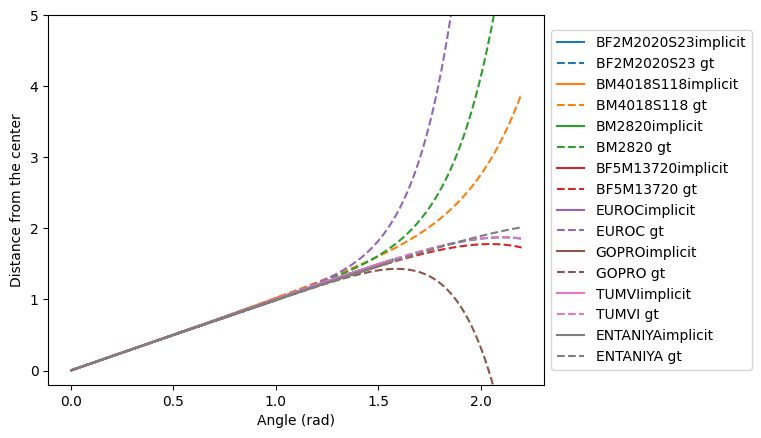

In [38]:
base_path = "/home/yihan/cvg/implicit_radial_sfm/experimental_scripts/babelcalib/eval/"
names = [
"BF2M2020S23",
 "BM4018S118",
"BM2820",
 "BF5M13720",
 "EUROC",
"GOPRO",
 "TUMVI",
 "ENTANIYA",
]
colors = [
"tab:blue",
 "tab:orange",
 "tab:green",
 "tab:red",
 "tab:purple",
 "tab:brown",
 "tab:pink",
"tab:gray",
 "tab:olive",
 "tab:cyan",
]
fs = {
"BF2M2020S23": 3.81437446e+02,
 "BF5M13720": 2.60390301e+02,
 "BM4018S118": 7.37663377e+02,
 "BM2820": 5.31040550e+02,
 "ENTANIYA":394.12332913,
 "EUROC": 460.83192281,
"GOPRO": 5.01199050e+02,
 "TUMVI": 1.90491382e+02
}
for i,name in enumerate(names):
    print(name)
    k1, k2, k3, k4 = ks[name]
    x = np.linspace(0, 2.2, num=1000)

    x_calc = x + k1*x**3 + k2 * x**5 +k3 * x**7 + k4 * x**9
    path = base_path + "Kalibr_"+name + "_theta_r.txt"
    theta = []
    r = []
    with open(path, 'r') as file:
        for line in file:
            line = line.strip()
            line = line.split()
            theta.append(float(line[0]))
            r.append(float(line[1]))
    plt.plot(theta, np.array(r)/fs[name], color=colors[i], label=name + 'implicit')
    plt.plot(x, x_calc, color=colors[i], linestyle="--", label=name + " gt")
plt.legend(loc="best")
# put lengend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.plot([0, 2], [0, 0], 'k--')
plt.xlabel("Angle (rad)")
plt.ylabel("Distance from the center")
plt.ylim(-0.2,5)

            